## Imports

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style(style="whitegrid")
from IPython.display import clear_output
import time
from IPython.display import HTML

# surpress warnings
import warnings
warnings.filterwarnings('ignore')

## Inspection

Read the data in from `.json` files:

In [2]:
df1 = pd.read_json('data/StreamingHistory0.json')
df2 = pd.read_json('data/StreamingHistory1.json')

Taking a peek at the pandas DataFrames

In [3]:
# Helper function for diplays
# Takes in DataFrame df and name of df
def print_head_tail(df, name):
    # print head
    print('{} head:'.format(name))
    print(df.head(), end="\n\n")

    # print tail
    print('{} tail:'.format(name))
    print(df.tail(), end="\n\n")
    print('<------------------------------------------------------------------------------>\n')


print_head_tail(df1, 'df1')
print_head_tail(df2, 'df2')

df1 head:
            endTime   artistName   trackName  msPlayed
0  2021-05-28 20:41  Leehom Wang      你不知道的事     59086
1  2022-04-21 00:01      BIGBANG  Still Life    188369
2  2022-04-21 00:04      BIGBANG  Still Life    188369
3  2022-04-21 00:07      BIGBANG  Still Life    188369
4  2022-04-21 00:08      BIGBANG  Still Life     31188

df1 tail:
               endTime       artistName   
9995  2022-12-14 03:57     Lil Uzi Vert  \
9996  2022-12-14 04:02     Lana Del Rey   
9997  2022-12-14 04:05  Stephen Sanchez   
9998  2022-12-14 04:08              SZA   
9999  2022-12-14 04:11     Harry Styles   

                                              trackName  msPlayed  
9995                                    Just Wanna Rock    123890  
9996  Did you know that there's a tunnel under Ocean...    285050  
9997                                  Until I Found You    177720  
9998                                              Shirt    181830  
9999                                          As I

Some important details to note first.

I requested my data on 4/18/2023, and I got an email on 4/22/2023 notifying me that my data was ready to download; took Spotify four days to aggregate my data.

The data in the DataFrames seem to be already sorted by `endTime`. Looking at this attribute, I found it strange that the first entry in `df1` has an `endTime` that dates back to the year $2021$. Overlooking this outlier, the data seems to span from $4/21/2022$ to $4/20/2023$, which is roughly a year. For this project, I will refer to this time span as $'22$ - $'23$.

### Combining DataFrames

Ideally, I want to work with as much data as possible, so want to combine `df1` and `df2`. As previously noted, since the data is already sorted by `endTime`, I can combine the two DataFrame together with a simple [`pandas.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html):

In [4]:
# Combine df1 and df2
combined_df = pd.concat([df1, df2], ignore_index=True) # ignore_index set to true to avoid duplicate indices
print_head_tail(combined_df, 'combined_df')

combined_df head:
            endTime   artistName   trackName  msPlayed
0  2021-05-28 20:41  Leehom Wang      你不知道的事     59086
1  2022-04-21 00:01      BIGBANG  Still Life    188369
2  2022-04-21 00:04      BIGBANG  Still Life    188369
3  2022-04-21 00:07      BIGBANG  Still Life    188369
4  2022-04-21 00:08      BIGBANG  Still Life     31188

combined_df tail:
                endTime    artistName          trackName  msPlayed
14094  2023-04-20 06:29  Michael Wong                 天堂    217053
14095  2023-04-20 07:03      NewJeans             Cookie    187870
14096  2023-04-20 07:15  Rachel Liang           分手後不要做朋友      1023
14097  2023-04-20 07:23   FIFTY FIFTY  Cupid - Twin Ver.    146752
14098  2023-04-20 07:51          Raon          残酷な天使のテーゼ    241253

<------------------------------------------------------------------------------>



### Top Artists

Below, I implement a Python function that returns a DataFrame of the top `num` artist in `df`. `display` can be set to `True` to print the DataFrame.

In [5]:
# Helper function to return the top `num` artist in DataFrame `df`. 
# If `display` is set to true, will also print the DataFrame`
def get_top_artist_df(df, name, num=25, display=False):
    top = df.groupby('artistName').size().sort_values(ascending=False).to_frame().reset_index().rename({0:'count'}, axis=1)
    top_display = top.head(num)

    # print if display
    if (display):
        print(name + " top {} artist(s):".format(num))
        print(top_display, end='\n<---------------------------------->\n\n')

    # return top artists DataFrame
    return top_display

Below, I display my top $25$ artists in `df1`, `df2`, and `combined_df`.

In [6]:
top_df1 = get_top_artist_df(df1, 'df1', display = True)
top_df2 = get_top_artist_df(df2, 'df2', display = True)
top_combined_df = get_top_artist_df(combined_df, 'combined_df', display = True)

df1 top 25 artist(s):
          artistName  count
0        Post Malone   1365
1               BIBI    557
2               Lauv    542
3             Halsey    480
4      The Kid LAROI    419
5           88rising    417
6        Alan Walker    380
7          Lil Nas X    286
8              Aimer    265
9         Marshmello    245
10        The Weeknd    216
11        Bebe Rexha    207
12              ZAYN    204
13             梶浦 由記    183
14             Seori    181
15        Stray Kids    166
16              KARD    155
17             Ne-Yo    151
18  The Chainsmokers    150
19             K-391    128
20      Hikaru Utada    120
21           Ava Max    110
22         SEVENTEEN     93
23        Steve Aoki     91
24              ASCA     87
<---------------------------------->

df2 top 25 artist(s):
            artistName  count
0          FIFTY FIFTY    367
1             NewJeans    366
2               MINSEO    263
3         Hikaru Utada    186
4             Eric Nam    140
5         

### `artistName` Outlier

As shown by the displays above, there is one outlier `artistName`: "**梶浦 由記**". This needs to be taken care of because while I was using `seaborn` to plot, I noticed that 梶浦 由記 turns into "[][] [][]" as shown below:

<div>
<img src="img/yuki_kajiura_error.png" width=250>
</div>

Thus I want to change "梶浦 由記" to its English equivalent. Searching up thereof on Spotify gave the following results:

<div>
<img src="img/yuki_kajiura.png" width=250>
</div>

This makes sense. I remember during 2022 Fall Semester, I often holed myself up in the dungeons of [Soda](https://www.google.com/maps/place/Soda+Hall,+Berkeley,+CA+94709/@37.8755939,-122.2613668,17z/data=!3m1!4b1!4m6!3m5!1s0x80857c23cf579a19:0xb391dd82cccd395f!8m2!3d37.8755939!4d-122.2587865!16s%2Fg%2F1q5hrxzsg) to do work while listening to [a tender feeling](https://open.spotify.com/track/4qGRptIf2ok9nHdDH6VwzW?si=97225ca02fc5497f).

To take care of this, I implement a Python function that specifically scans for "梶浦 由記" and replaces it with "Yuki Kajiura."

In [7]:
def replace_with_kajiura(df, verbose=False):
    try:
        replace_index = df[df['artistName']=="梶浦 由記"].index[0] # 0th index to get the int from list
        df.loc[replace_index, 'artistName'] = "Yuki Kajiura"
    except:
        if (verbose): # for debugging
            print("Nothing to replace")
        return # nothing to replace    

Testing the function on `top_combined_df`:

In [8]:
# call replace_with_kajuira on top_combined_df
replace_with_kajiura(top_combined_df)
top_combined_df.tail(8)

,artistName,count
17,Bebe Rexha,208
18,Seori,188
19,Yuki Kajiura,183
20,Stray Kids,166
21,Taylor Swift,162
22,The Chainsmokers,161
23,KARD,155
24,Eric Nam,140


As shown by the results, "梶浦 由記," which was originally in index position $19$ has been replaced by "Yuki Kajiura."

## Visualization

In this section, I create visualizations of my top artists using [`seaborn.barplot`](https://seaborn.pydata.org/generated/seaborn.barplot.html).

### Top Artists

I create three, with $'22$ , $'23$, and $'22$ - $'23$ corresponding to `df1`, `df2`, and `combined_df` respectively. Below I implement a Python function to do just that.

In [9]:
df1['endTime'].str.extract("([\d]{4}-[\d]{2}-[\d]{2})", expand=False).tail(1)

9999    2022-12-14
Name: endTime, dtype: object

In [10]:
# Takes in a DataFrame `df`, the number of top artists to display `num`,
# and the `name` of the df (in this case would be the time/time span)
# Displays a barplot visualization containing the count of each artist
def visualize_barplot(df, name, num=25):
    # get top artists by calling get_top_artist_df
    top_artists_df = get_top_artist_df(df, name=name, num=num)

    # replace yuki kajiura
    replace_with_kajiura(top_artists_df)

    # plot
    sns.barplot(data=top_artists_df, y='artistName', x='count', palette='crest_r')
    
    # formatting
    plt.title('Top {} Most Listened To Artist in '.format(num) + name)
    plt.ylabel("artist")
    plt.show()

To make the code and plotting more concise, I create another function that loops through all the time spans.

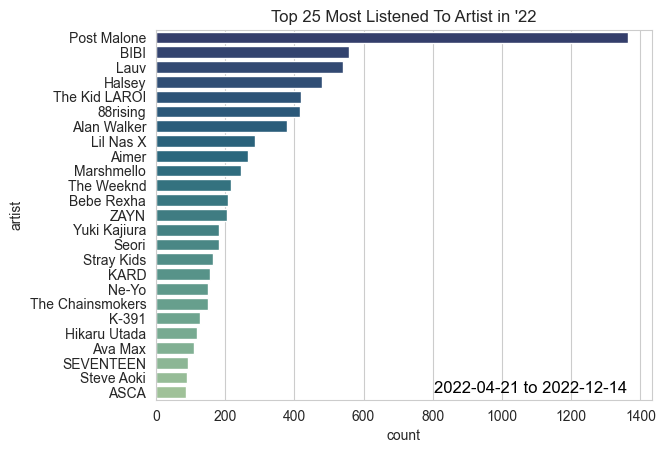

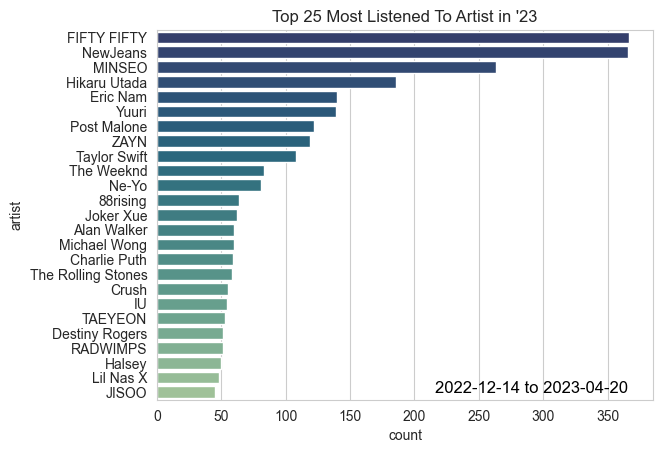

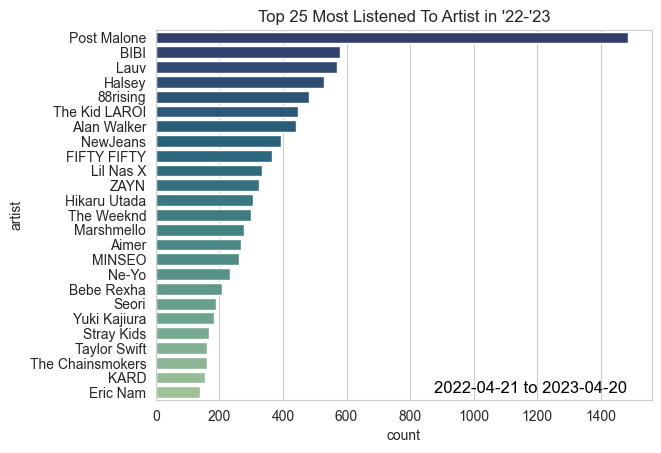

In [11]:
# Helper function to get the start and end endTime of a DataFrame
# Outliers will from df1 and combined_df will be removed
# Did not next in visualize_all_barplot because needed later in another function
# Return tuple (start, end)
def get_start_end(df, name):
    # instantiate pattern for regex
    date_pattern = "([\d]{4}-[\d]{2}-[\d]{2})"

    if (name == "'22" or name == "'22-'23"):
        start = df['endTime'].str.extract(date_pattern, expand=False)[1] # skip the 0th outlier in 2021
    else:
        start = df['endTime'].str.extract(date_pattern, expand=False)[0]
    end = df['endTime'].str.extract(date_pattern).tail(1)[0].iloc[0] # need to use iloc since index can vary

    return (start, end)

# Calls visualize_barplot on all the DataFrames, takes in a `num` dictating the top `num` artists
def visualize_all_barplot(num=25):
    # instantiate variables for loop
    all_dfs = [df1, df2, combined_df]
    all_df_years = ["'22", "'23", "'22-'23"]

    for df, df_year in zip(all_dfs, all_df_years):

        # get time-span
        start, end = get_start_end(df, df_year)

        # formatting: add start-end text in bottom right
        # https://matplotlib.org/stable/tutorials/text/text_intro.html
        fig= plt.figure()
        ax = fig.add_subplot()
        ax.text(0.95, 0.01, start + ' to ' + end,
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes,
                color='black', fontsize=12)
       
        # visualize
        visualize_barplot(df, df_year, num)

visualize_all_barplot()

It seems like for the latter half of $2022$, I was listening to a lot of pop music, with Post Malone being my most listened to artist by a very lage margin. If I recall, around this time I was just transitioning out of a k-r&b phase, which can be seen with BIBI and 88Rising holding some top spots. Other than Post Malone, it seems like I was really into American normie popular music, as indicated by artists like Lauv, Halsey, Alan Walker, and Lil Nas X. There are also some Japanese artists peppered in there like Aimer, Hikaru Utada, Yuki Kajiua, and ASCA.

Starting in the year of $2023$, I seem to have returned to a kpop phase, with FIFTY FIFTY, NewJeans, and Minseo, a k-ballad singer, taking the the top spots. Hikaru Utada also seems to have risen from the latter half of $2022$, and this is due to the Jdrama [*First Love*](https://en.wikipedia.org/wiki/First_Love_(2022_TV_series)) being released on Netflix in late November of 2022.

Post Malone albeit still near the top, has fallen off quite drastically, previously with a count of over $1300$ decreasing to less than $150$.

Two very interesting artists that rose up are Joker Xue and The Rolling Stones; C-pop and Rock artists respectively.

Overall, when looking at the entire year long duration combined, Post Malone is still undoubtedly first. BIBI, Lauv, Halsey, and 88Rising, giants in their respective years, also seem to maintain the top five spots. The new contenders of the year, FIFTY FIFTY and NewJeans, are no doubt climbing; I guess I'll see in the next few months how this will change.

### Top Artists Over Time

In [12]:
# df_name: "df1", "df2", "combined_df"
# year_name: "'22", "'23", "'22-'23"
def visualize_barplot_over_time(df, step, df_name, year_name, num):
    for i in range(step, len(df) + 1, step):
        # clear the plot
        clear_output(wait=True)
        # get slice of df
        curr_df = df[:i]

        # perform groupby
        curr_df_top_25 = get_top_artist_df(curr_df, df_name, num=num)
        
        # fix kajiura issue
        replace_with_kajiura(curr_df_top_25)

        # formatting: add start-end text in bottom right
        # https://matplotlib.org/stable/tutorials/text/text_intro.html
        start, end = get_start_end(curr_df, year_name)
        fig= plt.figure()
        ax = fig.add_subplot()
        ax.text(0.95, 0.01, start + ' to ' + end,
                verticalalignment='bottom', horizontalalignment='right',
                transform=ax.transAxes,
                color='black', fontsize=12)
        

        # visualize
        # color_palette: https://seaborn.pydata.org/tutorial/color_palettes.html
        # add "_r" to color_palette to reverse
        sns.color_palette("mako", as_cmap=True)
        sns.barplot(data=curr_df_top_25, y='artistName', x='count', palette="crest_r")
        plt.title("Top {} Most Listened To Artists".format(num))
        plt.ylabel("artist")
        plt.pause(10e-10)
        plt.show()                                                                                           

Below, I embed a video (using information from [w3schools]() and [this article](https://www.christopherlovell.co.uk/blog/2016/05/10/jupyter-video.html)) displaying the results of calling `visualize_barplot_over_time` on `combined_df`. More specifically, the following code was run:

`visualize_barplot_over_time(combined_df, step=50, df_name="combined_df", year_name="'22-'23", num=25)`

In [13]:
# Call visualize_barplot_over_time
# visualize_barplot_over_time(combined_df, step=50, df_name="combined_df", year_name="'22-'23", num=25) # uncomment to run code

<video width="850" height="460" controls autoplay=1>
<source src="vid/combined_df.mov">
</video>